<a href="https://colab.research.google.com/github/TheanLim/ReinforcementLearning/blob/master/Parkinsons.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load data

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import graphviz

from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from keras.models import Sequential
from keras.layers import  Dense, Dropout

# Comment this if the data visualisations doesn't work on your side
%matplotlib inline

# Set seed
np.random.seed(0)

url = 'https://raw.githubusercontent.com/TheanLim/ReinforcementLearning/master/data/parkinsons.data'
df = pd.read_csv(url)

In [406]:
# Take a look at the first five rows
df.head()

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,MDVP:APQ,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,0.426,0.02182,0.03130,0.02971,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,0.626,0.03134,0.04518,0.04368,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,0.482,0.02757,0.03858,0.03590,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,0.517,0.02924,0.04005,0.03772,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,0.584,0.03490,0.04825,0.04465,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


Attribute Information:

* name - ASCII subject name and recording number
* MDVP:Fo(Hz) - Average vocal fundamental frequency
* MDVP:Fhi(Hz) - Maximum vocal fundamental frequency
* MDVP:Flo(Hz) - Minimum vocal fundamental frequency
* MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP - Several 
measures of variation in fundamental frequency
* MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,MDVP:APQ,Shimmer:DDA - Several measures of variation in amplitude
* NHR,HNR - Two measures of ratio of noise to tonal components in the voice
* RPDE,D2 - Two nonlinear dynamical complexity measures
* DFA - Signal fractal scaling exponent
* spread1,spread2,PPE - Three nonlinear measures of fundamental frequency variation 
* **status** - Health status of the subject (one) - Parkinson's, (zero) - healthy

#Exploratory Data Analyses

Referring to : https://www.kaggle.com/ekami66/detailed-exploratory-data-analysis-with-python

In [0]:
plt.style.use('bmh')

In [408]:
# Check if any Nans exist
df.isnull().values.any()  # False; WE dont need to worry about missing values problem

False

## Numerical Value Distributions

In [409]:
list(set(df.dtypes.tolist()))

[dtype('int64'), dtype('float64'), dtype('O')]

All of the columns in this `df` is numerical except the `name` column - it is a categorical.

We also know that `df['name']` is useless because it only records patients name.

In [0]:
# Removing column 'name'
df = df.drop('name',1)

In [411]:
df_num = df.select_dtypes(include = ['float64', 'int64'])
df_num.head()  # Status is included here

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,MDVP:APQ,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,0.426,0.02182,0.03130,0.02971,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,0.626,0.03134,0.04518,0.04368,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,0.482,0.02757,0.03858,0.03590,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,0.517,0.02924,0.04005,0.03772,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,0.584,0.03490,0.04825,0.04465,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


Let's take a look at numerical data distributions.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5c6c16e1d0>,
      dtype=object)

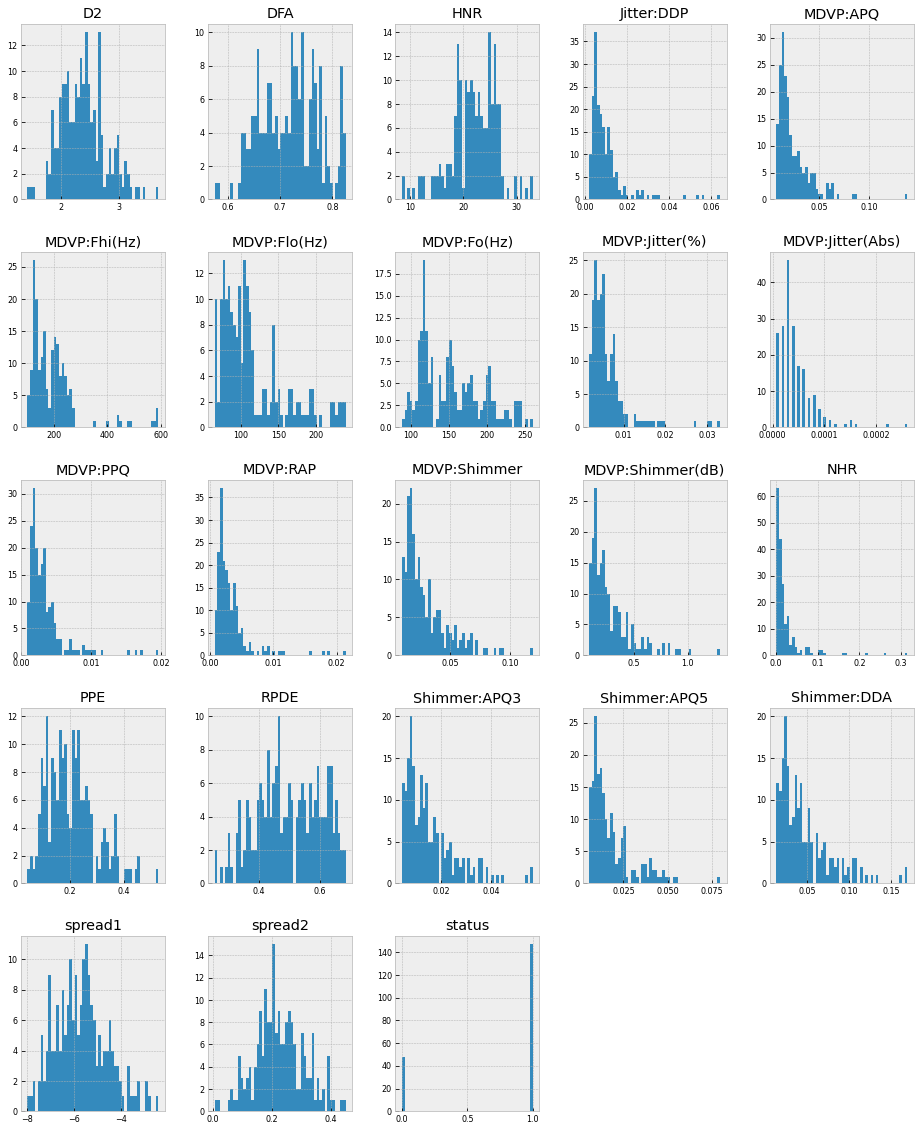

In [412]:
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)

The following shows correlation between each columns and `status`. `spread1`, `spread2` and `PPE` has high correlation with `status`.

In [413]:
df_num.corr()['status']

MDVP:Fo(Hz)        -0.383535
MDVP:Fhi(Hz)       -0.166136
MDVP:Flo(Hz)       -0.380200
MDVP:Jitter(%)      0.278220
MDVP:Jitter(Abs)    0.338653
MDVP:RAP            0.266668
MDVP:PPQ            0.288698
Jitter:DDP          0.266646
MDVP:Shimmer        0.367430
MDVP:Shimmer(dB)    0.350697
Shimmer:APQ3        0.347617
Shimmer:APQ5        0.351148
MDVP:APQ            0.364316
Shimmer:DDA         0.347608
NHR                 0.189429
HNR                -0.361515
status              1.000000
RPDE                0.308567
DFA                 0.231739
spread1             0.564838
spread2             0.454842
D2                  0.340232
PPE                 0.531039
Name: status, dtype: float64

## Target value distributions

Let's take a look at the distribution of the target value: `status`

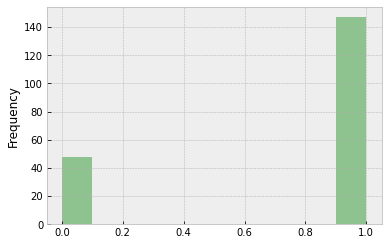

In [414]:
df_num['status'].plot.hist(color='g', alpha = 0.4)

In [415]:
# Distribution of Target value: Status
df_num['status'].describe()

count    195.000000
mean       0.753846
std        0.431878
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: status, dtype: float64

We are seeing the class imbalance problem: we have way more cases of Parkinson's disease than normal patients. A naive classifier would just classify a sample as Parkinson's 3 out of 4 times and will achieve a good accuracy. To be exact, count the occurences of `status` equals 0 and 1.

In [416]:
print("Number of status = 1 is", df_num.status[df_num.status==1].sum())

Number of status = 1 is 147


# Fixing imbalance data

In [0]:
# https://www.kdnuggets.com/2017/06/7-techniques-handle-imbalanced-data.html 

Take 40 from `status` 0 and 40 from `status` 1

# Models

* Logistic Regression
* Decision Tree
* Random Forest
* A Neural Network as a baseline

Use `df_num`

## Logistic Regression

In [418]:
df_num.columns

Index(['MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)',
       'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP',
       'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5',
       'MDVP:APQ', 'Shimmer:DDA', 'NHR', 'HNR', 'status', 'RPDE', 'DFA',
       'spread1', 'spread2', 'D2', 'PPE'],
      dtype='object')

In [0]:

# Train data index
index_0 = np.random.choice(df_num[df_num.status==0].index, 40, replace = False)
index_1 = np.random.choice(df_num[df_num.status==1].index, 40, replace = False)
train_ind = np.concatenate((index_0, index_1))

# Test data index
test_ind = [ind for ind in list(df_num.index) if ind not in train_ind]

In [0]:
# Split features and target dfs
df_num_Y = df_num.pop('status')
df_num_X = df_num

In [0]:
X_train = df_num_X.iloc[train_ind,:]
X_test = df_num_X.iloc[test_ind,:]

Y_train = df_num_Y.iloc[train_ind]
Y_test = df_num_Y.iloc[test_ind]

In [422]:
log_reg = LogisticRegression()
log_reg.fit(X_train, Y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Covergence fail above. Let's plan to scale each features.

In [423]:

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

scaler = StandardScaler()
scaler.fit(X_test)
X_test_scaled = scaler.transform(X_test)

log_reg_scaled = LogisticRegression()
log_reg_scaled.fit(X_train_scaled, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Convergence success! Let's check performances

Training Performance:72/80 accuracy

In [424]:
Y_train_pred = log_reg_scaled.predict(X_train_scaled)
confusion_matrix(Y_train, Y_train_pred)

array([[37,  3],
       [ 5, 35]])

Testing Performance: 66/115.

It seems like the model over-predict class 0 (the 49 instances). Why is that so?

In [425]:
Y_test_pred = log_reg_scaled.predict(X_test_scaled)

confusion_matrix(Y_test, Y_test_pred)

array([[ 8,  0],
       [49, 58]])

In [426]:
sum(Y_test_pred==0)

57

In [427]:
sum(Y_test_pred==1)

58

### Checking Coeffecients

In [0]:
coeffs = pd.DataFrame(
    data = log_reg_scaled.coef_[0,:],
    index = X_train.columns,
    columns = ['Coefficients']
)

In [429]:
coeffs.sort_values(ascending=True, by = ['Coefficients'])

,Coefficients
MDVP:Jitter(%),-0.510585
MDVP:PPQ,-0.422832
MDVP:Jitter(Abs),-0.276417
Shimmer:APQ3,-0.131825
Shimmer:DDA,-0.131773
MDVP:Flo(Hz),-0.070498
MDVP:Fo(Hz),-0.062321
NHR,-0.049403
MDVP:Fhi(Hz),0.065902
RPDE,0.123570


Let's pick the five featues with the largest coefficients

In [430]:
five_feat=coeffs.abs().nlargest(5, columns = 'Coefficients').index
print(five_feat)

Index(['MDVP:APQ', 'spread1', 'spread2', 'D2', 'MDVP:RAP'], dtype='object')


In [431]:
five_feat_indexes = [coeffs.index.to_list().index(item) for item in five_feat ]
print(five_feat_indexes)

[12, 18, 19, 20, 5]


In [432]:
print(coeffs.index)

Index(['MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)',
       'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP',
       'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5',
       'MDVP:APQ', 'Shimmer:DDA', 'NHR', 'HNR', 'RPDE', 'DFA', 'spread1',
       'spread2', 'D2', 'PPE'],
      dtype='object')


In [0]:
X_train_five = pd.DataFrame(X_train_scaled).iloc[:,five_feat_indexes]
X_test_five = pd.DataFrame(X_test_scaled).iloc[:,five_feat_indexes]

## Regularized Logistic Regression

In [434]:
c_log_reg_scaled = LogisticRegression(C=0.00001)
c_log_reg_scaled.fit(X_train_scaled, Y_train)

LogisticRegression(C=1e-05, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [435]:
Y_test_pred = log_reg_scaled.predict(X_test_scaled)
confusion_matrix(Y_test, Y_test_pred)

array([[ 8,  0],
       [49, 58]])

## Neural Networks

In [436]:


nn_simple_model = Sequential ([
                        Dense(1, activation = 'sigmoid', input_dim =22)
                        ])
nn_simple_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
nn_simple_model.fit(X_train_scaled, Y_train, epochs=100)

Epoch 1/100
80/80 [==============================] - 0s 748us/step - loss: 1.0472 - accuracy: 0.5000
Epoch 2/100
80/80 [==============================] - 0s 151us/step - loss: 1.0296 - accuracy: 0.5000
Epoch 3/100
80/80 [==============================] - 0s 113us/step - loss: 1.0102 - accuracy: 0.5125
Epoch 4/100
80/80 [==============================] - 0s 101us/step - loss: 0.9920 - accuracy: 0.5125
Epoch 5/100
80/80 [==============================] - 0s 121us/step - loss: 0.9729 - accuracy: 0.5125
Epoch 6/100
80/80 [==============================] - 0s 90us/step - loss: 0.9541 - accuracy: 0.5375
Epoch 7/100
80/80 [==============================] - 0s 92us/step - loss: 0.9370 - accuracy: 0.5375
Epoch 8/100
80/80 [==============================] - 0s 183us/step - loss: 0.9201 - accuracy: 0.5375
Epoch 9/100
80/80 [==============================] - 0s 101us/step - loss: 0.9020 - accuracy: 0.5375
Epoch 10/100
80/80 [==============================] - 0s 109us/step - loss: 0.8852 - accuracy

In [437]:
nn_simple_model.metrics_names  #['loss', 'accuracy']
nn_simple_model.evaluate(x=X_test_scaled, y=Y_test)

115/115 [==============================] - 0s 164us/step


[0.8526409688203231, 0.539130449295044]

In [438]:
nn_deep_model =  Sequential ([
                              Dense(10, activation= 'relu', input_dim =22),
                              Dropout(0.2),
                              Dense(5, activation = 'relu'),
                              Dropout(0.2),
                              Dense(1, activation = 'sigmoid'),
                              ])
nn_deep_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
nn_deep_model.fit(X_train_scaled, Y_train, epochs=100)

Epoch 1/100
80/80 [==============================] - 0s 2ms/step - loss: 0.9763 - accuracy: 0.4375
Epoch 2/100
80/80 [==============================] - 0s 144us/step - loss: 0.8364 - accuracy: 0.4500
Epoch 3/100
80/80 [==============================] - 0s 144us/step - loss: 0.8899 - accuracy: 0.4000
Epoch 4/100
80/80 [==============================] - 0s 148us/step - loss: 0.7978 - accuracy: 0.4625
Epoch 5/100
80/80 [==============================] - 0s 148us/step - loss: 0.8296 - accuracy: 0.4750
Epoch 6/100
80/80 [==============================] - 0s 154us/step - loss: 0.8102 - accuracy: 0.4500
Epoch 7/100
80/80 [==============================] - 0s 144us/step - loss: 0.7242 - accuracy: 0.5000
Epoch 8/100
80/80 [==============================] - 0s 148us/step - loss: 0.7422 - accuracy: 0.5000
Epoch 9/100
80/80 [==============================] - 0s 133us/step - loss: 0.6947 - accuracy: 0.4750
Epoch 10/100
80/80 [==============================] - 0s 227us/step - loss: 0.7076 - accuracy

In [439]:
nn_deep_model.evaluate(x=X_test_scaled, y=Y_test)

115/115 [==============================] - 0s 259us/step


[0.7151720819265946, 0.52173912525177]

## Decision Tree

In [440]:
print(X_train)
print(Y_train)
print(X_train_scaled)
print(Y_train_pred)

     MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  ...   spread2        D2       PPE
170      244.990       272.210       239.170  ...  0.171088  2.095237  0.096220
34       203.184       211.526       196.160  ...  0.163519  1.423287  0.044539
167      260.105       264.919       237.303  ...  0.160414  1.881767  0.075587
171      112.547       133.374       105.715  ...  0.218885  2.193412  0.160376
173      113.715       116.443        96.913  ...  0.192150  1.852542  0.179677
..           ...           ...           ...  ...       ...       ...       ...
139      116.150       131.731       109.815  ...  0.233070  2.445646  0.184985
8         95.730       132.068        91.754  ...  0.327769  2.322511  0.231571
68       143.533       162.215        65.809  ...  0.151814  2.118496  0.185580
120      128.940       479.697        88.251  ...  0.279933  2.686240  0.152428
153      121.345       139.644        98.250  ...  0.246404  2.013530  0.168581

[80 rows x 22 columns]
170    0
34     

In [441]:
print(X_test)
print(Y_test)
print(X_test_scaled)
print(Y_test_pred)

     MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  ...   spread2        D2       PPE
0        119.992       157.302        74.997  ...  0.266482  2.301442  0.284654
1        122.400       148.650       113.819  ...  0.335590  2.486855  0.368674
2        116.682       131.111       111.555  ...  0.311173  2.342259  0.332634
3        116.676       137.871       111.366  ...  0.334147  2.405554  0.368975
6        120.267       137.244       114.820  ...  0.257682  1.854785  0.211756
..           ...           ...           ...  ...       ...       ...       ...
180      150.440       163.441       144.736  ...  0.183218  2.264226  0.144105
182      149.818       163.417       144.786  ...  0.109397  2.209021  0.156368
186      116.556       592.030        86.228  ...  0.153310  2.161936  0.120605
191      209.516       253.017        89.488  ...  0.129303  2.784312  0.168895
192      174.688       240.005        74.287  ...  0.158453  2.679772  0.131728

[115 rows x 22 columns]
0      1
1     

In [442]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, Y_train)
Y_test_pred = clf.predict(X_test)
print(Y_test.to_numpy())
print(Y_test_pred)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 0 0]
[1 1 1 1 0 1 1 0 0 0 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1 0 0 0 0 1 1 1 1 0 1 1 1
 1 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 0 0 1 1 1 1 1 0 0 0 1 1
 1 1 1 0 1 1 0 0 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 1 1
 0 0 1 0]


In [0]:
# tree.plot_tree(clf)

In [444]:
confusion_matrix(Y_test.to_numpy(), Y_test_pred)

array([[ 6,  2],
       [29, 78]])

In [448]:
mean_squared_error(Y_test.to_numpy(), Y_test_pred, squared=False) # RMSE

0.5191967039488062

In [449]:
mean_squared_error(Y_test.to_numpy(), Y_test_pred, squared=True) # MSE

0.26956521739130435

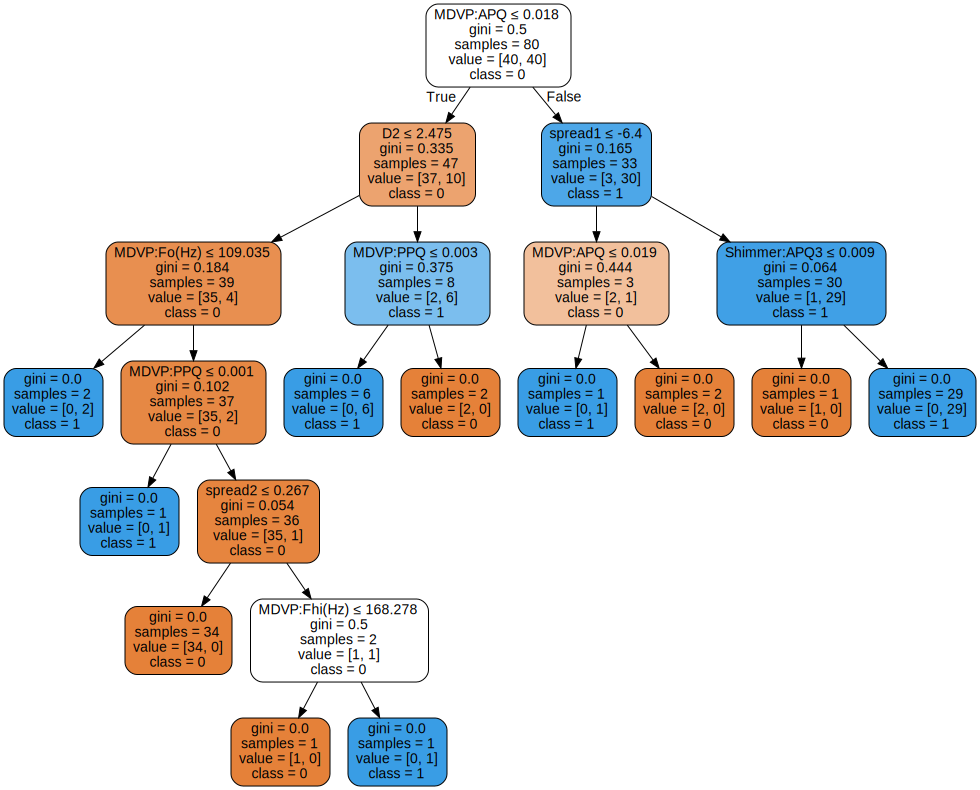

In [447]:
dot_data = tree.export_graphviz(
    clf, 
    out_file=None, 
    feature_names=X_train.columns, 
    class_names=[str(num) for num in Y_train.unique()],
    filled=True, rounded=True, special_characters=True
)
graph = graphviz.Source(dot_data)
graph